In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageEnhance
import albumentations as albu
from tqdm.notebook import tqdm

print("The necessary libraries were succesfully imported !!!")

The necessary libraries were succesfully imported !!!


In [2]:
labels = pd.read_csv('train.csv')
labels.head()

image_id  width  height                         bbox   source
0  b6ab77fd7   1024    1024   [834.0, 222.0, 56.0, 36.0]  usask_1
1  b6ab77fd7   1024    1024  [226.0, 548.0, 130.0, 58.0]  usask_1
2  b6ab77fd7   1024    1024  [377.0, 504.0, 74.0, 160.0]  usask_1
3  b6ab77fd7   1024    1024  [834.0, 95.0, 109.0, 107.0]  usask_1
4  b6ab77fd7   1024    1024  [26.0, 144.0, 124.0, 117.0]  usask_1

In [3]:
print("The number of image ids is {}".format(labels["image_id"].nunique()))

The number of image ids is 3373


In [4]:
print("The number of rows: {}".format(labels.shape[0]))
print("The number of columns: {}".format(labels.shape[1]))

The number of rows: 147793
The number of columns: 5


In [5]:
def group_boxes(group):
    boundaries = group["bbox"].str.split(",", expand = True)
    boundaries[0] = boundaries[0].str.slice(start = 1)
    boundaries[3] = boundaries[3].str.slice(stop = -1)
    
    return boundaries.values.astype(float)

labels = labels.groupby("image_id").apply(group_boxes)
labels

image_id
00333207f    [[0.0, 654.0, 37.0, 111.0], [0.0, 817.0, 135.0...
005b0d8bb    [[765.0, 879.0, 116.0, 79.0], [84.0, 539.0, 15...
006a994f7    [[437.0, 988.0, 98.0, 36.0], [309.0, 527.0, 11...
00764ad5d    [[89.0, 256.0, 113.0, 107.0], [216.0, 282.0, 1...
00b5fefed    [[709.0, 97.0, 204.0, 105.0], [775.0, 250.0, 1...
                                   ...                        
ffb445410    [[0.0, 534.0, 54.0, 118.0], [0.0, 480.0, 38.0,...
ffbf75e5b    [[0.0, 697.0, 21.0, 58.0], [104.0, 750.0, 77.0...
ffbfe7cc0    [[256.0, 0.0, 64.0, 99.0], [390.0, 0.0, 48.0, ...
ffc870198    [[447.0, 976.0, 78.0, 48.0], [18.0, 141.0, 218...
ffdf83e42    [[306.0, 178.0, 67.0, 88.0], [367.0, 167.0, 63...
Length: 3373, dtype: object

In [6]:
labels["ffc870198"][0:10]

array([[ 447.,  976.,   78.,   48.],
       [  18.,  141.,  218.,  126.],
       [ 704.,  687.,   79.,   78.],
       [ 943.,  842.,   81.,  143.],
       [ 361.,  222.,  178.,   70.],
       [ 373.,   34.,  103.,   68.],
       [1010.,    0.,   14.,   42.],
       [ 585.,  906.,  115.,   45.],
       [   0.,  906.,   68.,   88.],
       [ 309.,  323.,  110.,  103.]])

In [7]:
train_image_ids = np.unique(labels.index.values)[0:3363]
val_image_ids = np.unique(labels.index.values)[3363:3373]

In [8]:
def load_image(image_id):
    image = Image.open('../input/global-wheat-detection/train/' + image_id + ".jpg")
    image = image.resize((256, 256))
    
    return np.asarray(image)

In [9]:
train_pixels = {}
train_labels = {}

for image_id in tqdm(train_image_ids):
    train_pixels[image_id] = load_image(image_id)
    train_labels[image_id] = labels[image_id].copy() / 4

In [10]:
val_pixels = {}
val_labels = {}

for image_id in tqdm(val_image_ids):
    val_pixels[image_id] = load_image(image_id)    
    val_labels[image_id] = labels[image_id].copy() / 4

In [11]:
def draw_bboxes(image_id, bboxes, source = "train"):  
    image = Image.open('../input/global-wheat-detection/' + source +'/' + image_id + ".jpg")
    image = image.resize((256,256))
    
    draw = ImageDraw.Draw(image)
            
    for bbox in bboxes:
        draw_bbox(draw, bbox)
    
    return np.asarray(image)


def draw_bbox(draw, bbox):
    x, y, width, height = bbox
    draw.rectangle([x, y, x + width, y + height], width = 2, outline='red')

In [12]:
def show_images(image_ids, bboxes, source = 'train'):
    pixels = []
    
    for image_id in image_ids:
        pixels.append(
            draw_bboxes(image_id, bboxes[image_id], source)
        )
    
    num_of_images = len(image_ids)
    fig, axes = plt.subplots( 1, num_of_images, figsize = (5 * num_of_images, 5 * num_of_images))
    
    for i, image_pixels in enumerate(pixels):
        axes[i].imshow(image_pixels)

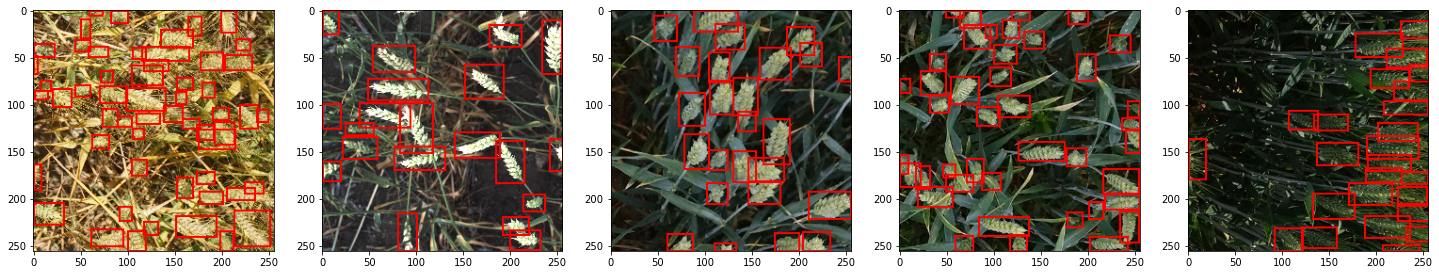

In [13]:
show_images(train_image_ids[0:5], train_labels)

In [14]:
tiny_bboxes = []

for i, image_id in enumerate(train_image_ids):
    for label in train_labels[image_id]:
        if label[2] * label[3] <= 10 and label[2] * label[3] != 0:
            tiny_bboxes.append(i)

            
print(str(len(tiny_bboxes)) + " tiny bounding boxes found")

50 tiny bounding boxes found


In [15]:
huge_bboxes = []

for i, image_id in enumerate(train_image_ids):
    for label in train_labels[image_id]:
        if label[2] * label[3] > 8000:
            huge_bboxes.append(i)

            
print(str(len(huge_bboxes)) + " huge bounding boxes found")

13 huge bounding boxes found


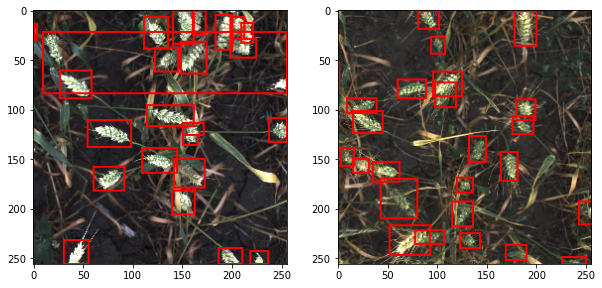

In [16]:
show_images(train_image_ids[562:564], train_labels)

In [17]:
def clean_labels(train_image_ids, train_labels):
    good_labels = {}
    
    for i, image_id in enumerate(train_image_ids):
        good_labels[image_id] = []
        
        for j, label in enumerate(train_labels[image_id]):

            # remove huge bbox
            if label[2] * label[3] > 8000 and i not in [1079, 1371, 2020]:
                continue

            # remove tiny bbox
            elif label[2] < 5 or label[3] < 5:
                continue
                
            else:
                good_labels[image_id].append(
                    train_labels[image_id][j]
                )
                
    return good_labels

train_labels = clean_labels(train_image_ids, train_labels)

In [18]:
class DataGenerator(tf.keras.utils.Sequence):

    def __init__(self, image_ids, image_pixels, labels = None, batch_size = 1, shuffle = False, augment = False):
        self.image_ids = image_ids
        self.image_pixels = image_pixels
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        self.on_epoch_end()
        
        self.image_grid = self.form_image_grid()
        
        
    def form_image_grid(self):    
        image_grid = np.zeros((32, 32, 4))

        # x, y, width, height
        cell = [0, 0, 256 / 32, 256 / 32] 

        for i in range(0, 32):
            for j in range(0, 32):
                image_grid[i,j] = cell

                cell[0] = cell[0] + cell[2]

            cell[0] = 0
            cell[1] = cell[1] + cell[3]

        return image_grid

In [19]:
def __len__(self):
    return int(np.floor(len(self.image_ids) / self.batch_size))


def on_epoch_end(self):
    self.indexes = np.arange(len(self.image_ids))

    if self.shuffle == True:
        np.random.shuffle(self.indexes)


DataGenerator.__len__ = __len__
DataGenerator.on_epoch_end = on_epoch_end

In [20]:
DataGenerator.train_augmentations = albu.Compose([
        albu.RandomSizedCrop(
            min_max_height=(200, 200), 
            height=256, 
            width=256, 
            p=0.8
        ),
        albu.OneOf([
            albu.Flip(),
            albu.RandomRotate90(),
        ], p=1),
        albu.OneOf([
            albu.HueSaturationValue(),
            albu.RandomBrightnessContrast()
        ], p=1),
        albu.OneOf([
            albu.GaussNoise(),
            albu.GlassBlur(),
            albu.ISONoise(),
            albu.MultiplicativeNoise(),
        ], p=0.5),
        albu.Cutout(
            num_holes=8, 
            max_h_size=16, 
            max_w_size=16, 
            fill_value=0, 
            p=0.5
        ),
        albu.CLAHE(p=1),
        albu.ToGray(p=1),
    ], 
    bbox_params={'format': 'coco', 'label_fields': ['labels']})

DataGenerator.val_augmentations = albu.Compose([
    albu.CLAHE(p=1),
    albu.ToGray(p=1),
])

In [21]:
def __getitem__(self, index):
    indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

    batch_ids = [self.image_ids[i] for i in indexes]

    X, y = self.__data_generation(batch_ids)

    return X, y


def __data_generation(self, batch_ids):
    X, y = [], []

    # Generate data
    for i, image_id in enumerate(batch_ids):
        pixels = self.image_pixels[image_id]
        bboxes = self.labels[image_id]

        if self.augment:     
            pixels, bboxes = self.augment_image(pixels, bboxes)
        else:
            pixels = self.contrast_image(pixels)
            bboxes = self.form_label_grid(bboxes)

        X.append(pixels)
        y.append(bboxes)

    return np.array(X), np.array(y)


def augment_image(self, pixels, bboxes):
    bbox_labels = np.ones(len(bboxes))

    aug_result = self.train_augmentations(image=pixels, bboxes=bboxes, labels=bbox_labels)

    bboxes = self.form_label_grid(aug_result['bboxes'])

    return np.array(aug_result['image']) / 255, bboxes


def contrast_image(self, pixels):        
    aug_result = self.val_augmentations(image=pixels)
    return np.array(aug_result['image']) / 255


DataGenerator.__getitem__ = __getitem__
DataGenerator.__data_generation = __data_generation
DataGenerator.augment_image = augment_image
DataGenerator.contrast_image = contrast_image

In [22]:
def form_label_grid(self, bboxes):
    label_grid = np.zeros((32, 32, 10))

    for i in range(0, 32):
        for j in range(0, 32):
            cell = self.image_grid[i,j]
            label_grid[i,j] = self.rect_intersect(cell, bboxes)

    return label_grid


def rect_intersect(self, cell, bboxes): 
    cell_x, cell_y, cell_width, cell_height = cell
    cell_x_max = cell_x + cell_width 
    cell_y_max = cell_y + cell_height
    
    anchor_one = np.array([0, 0, 0, 0, 0])
    anchor_two = np.array([0, 0, 0, 0, 0])

    # check all boxes
    for bbox in bboxes:
        box_x, box_y, box_width, box_height = bbox
        box_x_centre = box_x + (box_width / 2)
        box_y_centre = box_y + (box_height / 2)

        if(box_x_centre >= cell_x and box_x_centre < cell_x_max and box_y_centre >= cell_y and box_y_centre < cell_y_max):
            
            if anchor_one[0] == 0:
                anchor_one = self.yolo_shape(
                    [box_x, box_y, box_width, box_height], 
                    [cell_x, cell_y, cell_width, cell_height]
                )
            
            elif anchor_two[0] == 0:
                anchor_two = self.yolo_shape(
                    [box_x, box_y, box_width, box_height], 
                    [cell_x, cell_y, cell_width, cell_height]
                )
                
            else:
                break

    return np.concatenate((anchor_one, anchor_two), axis=None)


def yolo_shape(self, box, cell):
    box_x, box_y, box_width, box_height = box
    cell_x, cell_y, cell_width, cell_height = cell

    # top left x,y to centre x,y
    box_x = box_x + (box_width / 2)
    box_y = box_y + (box_height / 2)

    # offset bbox x,y to cell x,y
    box_x = (box_x - cell_x) / cell_width
    box_y = (box_y - cell_y) / cell_height

    # bbox width,height relative to cell width,height
    box_width = box_width / 256
    box_height = box_height / 256

    return [1, box_x, box_y, box_width, box_height]


DataGenerator.form_label_grid = form_label_grid
DataGenerator.rect_intersect = rect_intersect
DataGenerator.yolo_shape = yolo_shape

In [23]:
train_generator = DataGenerator(
    train_image_ids,
    train_pixels,
    train_labels, 
    batch_size = 6, 
    shuffle = True,
    augment = True
)

val_generator = DataGenerator(
    val_image_ids, 
    val_pixels,
    val_labels, 
    batch_size = 10,
    shuffle = False,
    augment = False
)

image_grid = train_generator.image_grid

In [24]:
x_input = tf.keras.Input(shape = (256,256,3))

x = tf.keras.layers.Conv2D(32, (3, 3), strides = (1, 1), padding = 'same')(x_input)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha = 0.1)(x)

########## block 1 ##########
x = tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding = 'same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

x_shortcut = x

for i in range(2):
    x = tf.keras.layers.Conv2D(32, (3, 3), strides=(1, 1), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha = 0.1)(x)

    x = tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Add()([x_shortcut, x])
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x_shortcut = x


########## block 2 ##########
x = tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

x_shortcut = x

for i in range(2):
    x = tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Add()([x_shortcut, x])
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x_shortcut = x

########## block 3 ##########
x = tf.keras.layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

x_shortcut = x

for i in range(8):
    x = tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Add()([x_shortcut, x])
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x_shortcut = x

    
########## block 4 ##########
x = tf.keras.layers.Conv2D(512, (3, 3), strides=(2, 2), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

x_shortcut = x

for i in range(8):
    x = tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Add()([x_shortcut, x])
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x_shortcut = x

########## block 5 ##########
x = tf.keras.layers.Conv2D(1024, (3, 3), strides=(2, 2), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

x_shortcut = x

for i in range(4):
    x = tf.keras.layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Conv2D(1024, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Add()([x_shortcut, x])
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x_shortcut = x

########## output layers ##########
x = tf.keras.layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

x = tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

x = tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

predictions = tf.keras.layers.Conv2D(10, (1, 1), strides=(1, 1), activation='sigmoid')(x)

model = tf.keras.Model(inputs=x_input, outputs=predictions)

In [25]:
def custom_loss(y_true, y_pred):
    binary_crossentropy = prob_loss = tf.keras.losses.BinaryCrossentropy(
        reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE
    )
    
    prob_loss = binary_crossentropy(
        tf.concat([y_true[:,:,:,0], y_true[:,:,:,5]], axis=0), 
        tf.concat([y_pred[:,:,:,0], y_pred[:,:,:,5]], axis=0)
    )
    
    xy_loss = tf.keras.losses.MSE(
        tf.concat([y_true[:,:,:,1:3], y_true[:,:,:,6:8]], axis=0), 
        tf.concat([y_pred[:,:,:,1:3], y_pred[:,:,:,6:8]], axis=0)
    )
    
    wh_loss = tf.keras.losses.MSE(
        tf.concat([y_true[:,:,:,3:5], y_true[:,:,:,8:10]], axis=0), 
        tf.concat([y_pred[:,:,:,3:5], y_pred[:,:,:,8:10]], axis=0)
    )
    
    bboxes_mask = get_mask(y_true)
    
    xy_loss = xy_loss * bboxes_mask
    wh_loss = wh_loss * bboxes_mask
    
    return prob_loss + xy_loss + wh_loss


def get_mask(y_true):
    anchor_one_mask = tf.where(
        y_true[:,:,:,0] == 0, 
        0.5, 
        5.0
    )
    
    anchor_two_mask = tf.where(
        y_true[:,:,:,5] == 0, 
        0.5, 
        5.0
    )
    
    bboxes_mask = tf.concat(
        [anchor_one_mask,anchor_two_mask],
        axis=0
    )
    
    return bboxes_mask

In [26]:
optimiser = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(
    optimizer=optimiser, 
    loss=custom_loss
)

In [27]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=2, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1, restore_best_weights=True),
]

In [28]:
history = model.fit_generator(
    train_generator,
    validation_data=val_generator,
    epochs=80,
    callbacks=callbacks
)

Train for 560 steps, validate for 1 steps
Epoch 1/80
560/560 [==============================] - 523s 934ms/step - loss: 0.2409 - val_loss: 0.2589
Epoch 2/80
560/560 [==============================] - 509s 908ms/step - loss: 0.0971 - val_loss: 0.0903
Epoch 3/80
560/560 [==============================] - 508s 908ms/step - loss: 0.0747 - val_loss: 0.0761
Epoch 4/80
560/560 [==============================] - 508s 908ms/step - loss: 0.0662 - val_loss: 0.0669
Epoch 5/80
560/560 [==============================] - 508s 907ms/step - loss: 0.0606 - val_loss: 0.0779
Epoch 6/80
560/560 [==============================] - 508s 908ms/step - loss: 0.0575 - val_loss: 0.0681
Epoch 7/80
560/560 [==============================] - 508s 908ms/step - loss: 0.0552 - val_loss: 0.0586
Epoch 8/80
560/560 [==============================] - 508s 907ms/step - loss: 0.0533 - val_loss: 0.0647
Epoch 9/80
560/560 [==============================] - 508s 908ms/step - loss: 0.0522 - val_loss: 0.0564
Epoch 10/80
560/560 [=

In [29]:
def prediction_to_bbox(bboxes, image_grid):    
    bboxes = bboxes.copy()
    
    im_width = (image_grid[:,:,2] * 32)
    im_height = (image_grid[:,:,3] * 32)
    
    # descale x,y
    bboxes[:,:,1] = (bboxes[:,:,1] * image_grid[:,:,2]) + image_grid[:,:,0]
    bboxes[:,:,2] = (bboxes[:,:,2] * image_grid[:,:,3]) + image_grid[:,:,1]
    bboxes[:,:,6] = (bboxes[:,:,6] * image_grid[:,:,2]) + image_grid[:,:,0]
    bboxes[:,:,7] = (bboxes[:,:,7] * image_grid[:,:,3]) + image_grid[:,:,1]
    
    # descale width,height
    bboxes[:,:,3] = bboxes[:,:,3] * im_width 
    bboxes[:,:,4] = bboxes[:,:,4] * im_height
    bboxes[:,:,8] = bboxes[:,:,8] * im_width 
    bboxes[:,:,9] = bboxes[:,:,9] * im_height
    
    # centre x,y to top left x,y
    bboxes[:,:,1] = bboxes[:,:,1] - (bboxes[:,:,3] / 2)
    bboxes[:,:,2] = bboxes[:,:,2] - (bboxes[:,:,4] / 2)
    bboxes[:,:,6] = bboxes[:,:,6] - (bboxes[:,:,8] / 2)
    bboxes[:,:,7] = bboxes[:,:,7] - (bboxes[:,:,9] / 2)
    
    # width,heigth to x_max,y_max
    bboxes[:,:,3] = bboxes[:,:,1] + bboxes[:,:,3]
    bboxes[:,:,4] = bboxes[:,:,2] + bboxes[:,:,4]
    bboxes[:,:,8] = bboxes[:,:,6] + bboxes[:,:,8]
    bboxes[:,:,9] = bboxes[:,:,7] + bboxes[:,:,9]
    
    return bboxes

In [30]:
def non_max_suppression(predictions, top_n):
    probabilities = np.concatenate((predictions[:,:,0].flatten(), predictions[:,:,5].flatten()), axis=None)
    
    first_anchors = predictions[:,:,1:5].reshape((32*32, 4))
    second_anchors = predictions[:,:,6:10].reshape((32*32, 4))
    
    bboxes = np.concatenate(
        (first_anchors,second_anchors),
        axis=0
    )
    
    bboxes = switch_x_y(bboxes)
    bboxes, probabilities = select_top(probabilities, bboxes, top_n=top_n)
    bboxes = switch_x_y(bboxes)
    
    return bboxes


def switch_x_y(bboxes):
    x1 = bboxes[:,0].copy()
    y1 = bboxes[:,1].copy()
    x2 = bboxes[:,2].copy()
    y2 = bboxes[:,3].copy()
    
    bboxes[:,0] = y1
    bboxes[:,1] = x1
    bboxes[:,2] = y2
    bboxes[:,3] = x2
    
    return bboxes


def select_top(probabilities, boxes, top_n=10):
    top_indices = tf.image.non_max_suppression(
        boxes = boxes, 
        scores = probabilities, 
        max_output_size = top_n, 
        iou_threshold = 0.3,
        score_threshold = 0.3
    )
    
    top_indices = top_indices.numpy()
    
    return boxes[top_indices], probabilities[top_indices]

In [31]:
def process_predictions(predictions, image_ids, image_grid):
    bboxes = {}
    
    for i, image_id in enumerate(image_ids):
        predictions[i] = prediction_to_bbox(predictions[i], image_grid)
        bboxes[image_id] = non_max_suppression(predictions[i], top_n=100)
        
        # back to coco shape
        bboxes[image_id][:,2:4] = bboxes[image_id][:,2:4] - bboxes[image_id][:,0:2]
    
    return bboxes

In [32]:
val_predictions = model.predict(val_generator)
val_predictions = process_predictions(val_predictions, val_image_ids, image_grid)

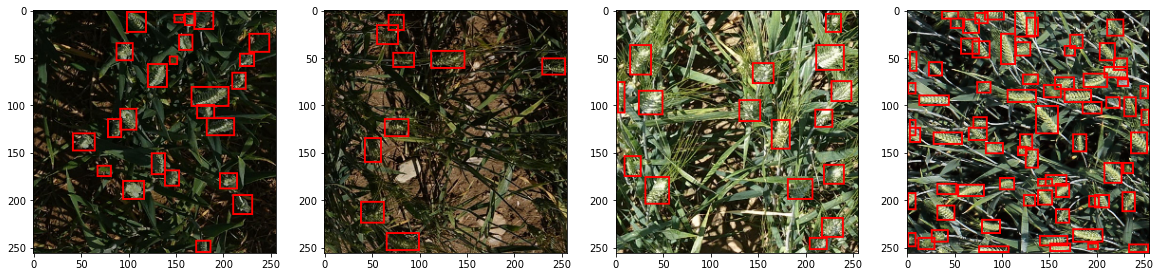

In [33]:
show_images(val_image_ids[0:4], val_predictions)

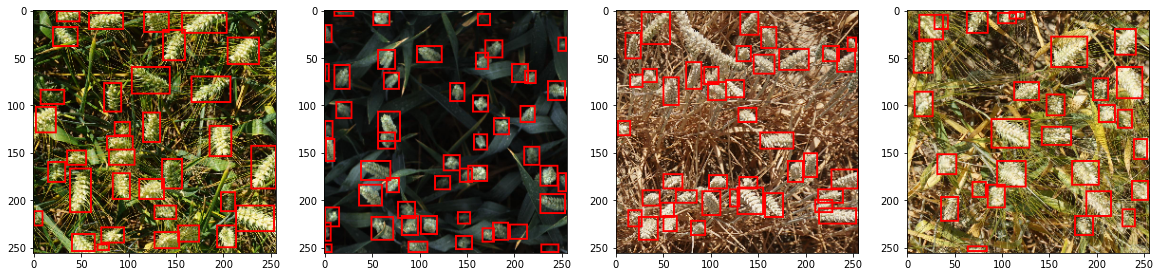

In [34]:
show_images(val_image_ids[4:8], val_predictions)

In [35]:
print('Epochs: ' + str(len(history.history['loss'])))
print('Final training loss: ' + str(history.history['loss'][-1]))
print('Final validation loss: ' + str(history.history['val_loss'][-1]))

Epochs: 52
Final training loss: 0.040168484689534774
Final validation loss: 0.039805591106414795


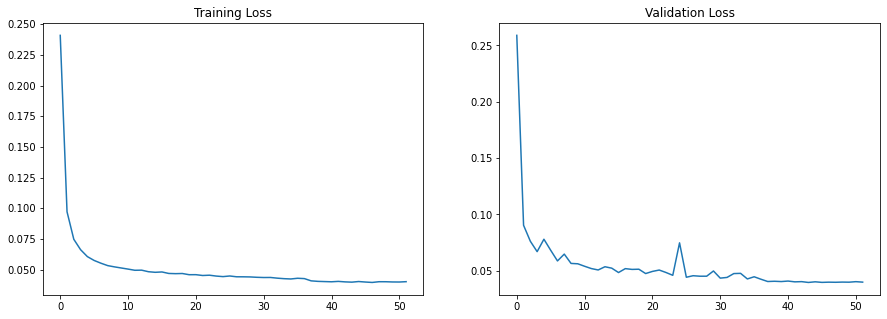

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].set_title('Training Loss')
ax[0].plot(history.history['loss'])

ax[1].set_title('Validation Loss')
ax[1].plot(history.history['val_loss'])

In [37]:
layer_outputs = [layer.output for layer in model.layers]
evaluation_model = tf.keras.Model(inputs=model.input, outputs=layer_outputs)

In [38]:
image = Image.open('../input/global-wheat-detection/train/' + train_image_ids[1] + ".jpg")
image = image.resize((256, 256))

pixels = np.asarray(image) / 255
pixels = np.expand_dims(pixels, axis=0)

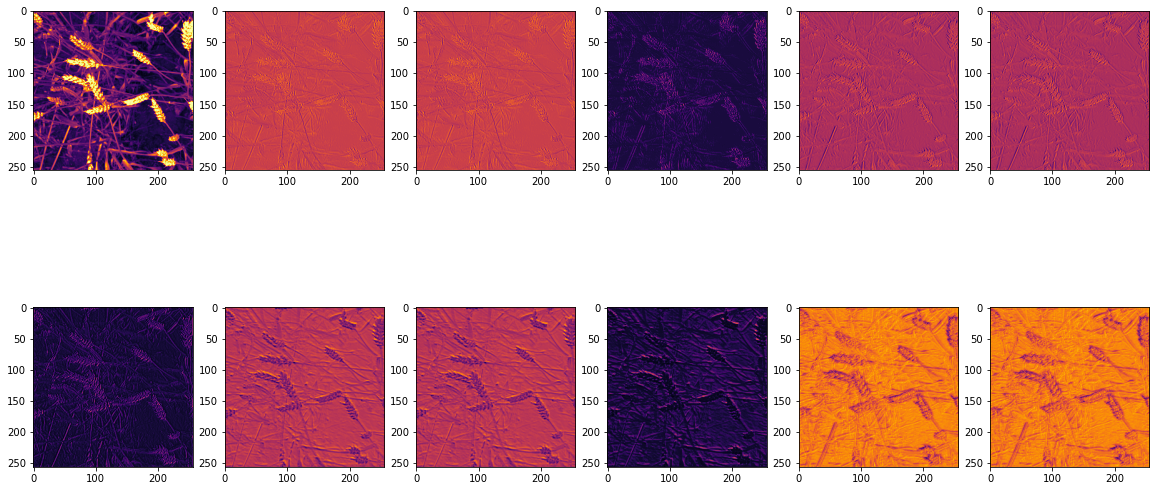

In [39]:
num_of_layers = len(layer_outputs)

fig, axes = plt.subplots(2, 6, figsize=(20, 10))

layer = 0
for i in range(0, 2):
    for j in range(0, 6):
        layer_output = evaluation_model.predict(pixels)[layer]
        axes[i, j].imshow(layer_output[0, :, :, 1], cmap='inferno')
        
        layer = layer + 1

In [40]:
test_image_ids = os.listdir('/test/')
test_image_ids = [image_id[:-4] for image_id in test_image_ids]

In [41]:
test_predictions = []

for i, image_id in enumerate(test_image_ids):
    image = Image.open('/test/' + image_id + ".jpg")
    image = image.resize((256, 256))            

    pixels = np.asarray(image)

    val_augmentations = albu.Compose([
        albu.CLAHE(p=1),
        albu.ToGray(p=1)
    ])

    aug_result = val_augmentations(image=pixels)
    pixels = np.array(aug_result['image']) / 255
    
    pixels = np.expand_dims(pixels, axis=0)
    
    bboxes = model.predict(pixels)

    test_predictions.append(bboxes)
    
test_predictions = np.concatenate(test_predictions)

In [42]:
test_predictions = process_predictions(test_predictions, test_image_ids, image_grid)

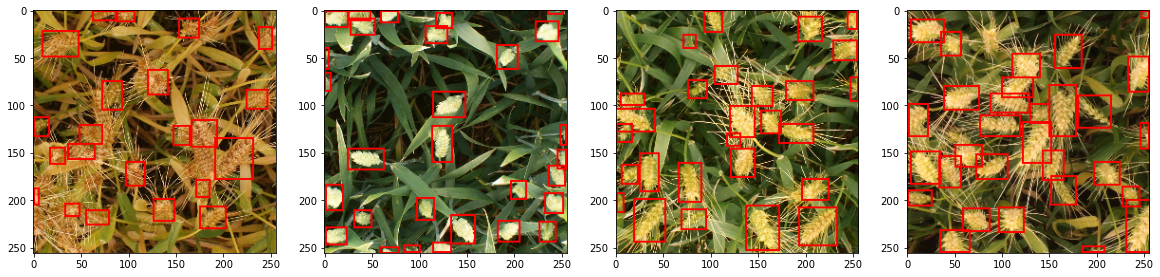

In [43]:
show_images(test_image_ids[0:4], test_predictions, source='test')

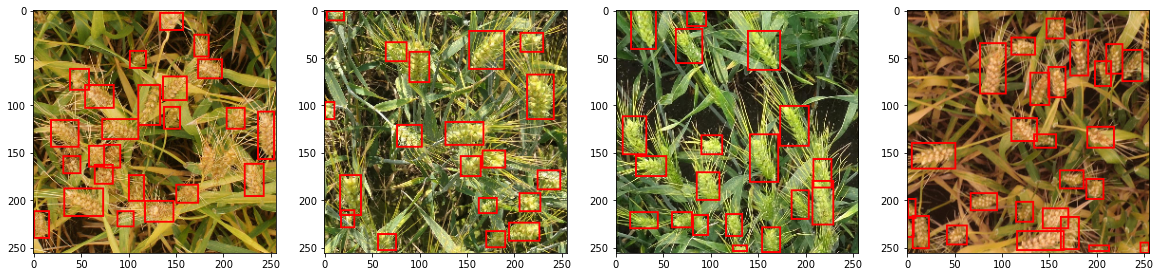

In [44]:
show_images(test_image_ids[4:8], test_predictions, source='test')

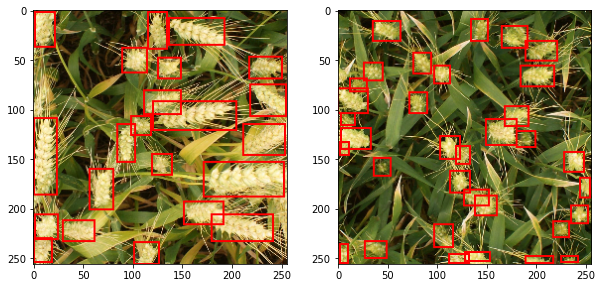

In [45]:
show_images(test_image_ids[8:10], test_predictions, source='test')

In [46]:
model.save_weights('wheat_detection_model')